In [ ]:
# ---------------------
# Variance reduction with daily aggregation
# ---------------------

from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

SOURCE_DELTA_PATH = "/Volumes/workspace/default/ita"
df = spark.read.format("delta").load(SOURCE_DELTA_PATH)

obs_df = df.filter((F.col("file_date") <= F.lit("2025-01-10")))

# Aggregate views by day + hour (file_time assumed to be hhmmss or hh)
hourly = (
    obs_df.withColumn("hour", F.substring("file_time", 1, 2).cast("int"))
      .groupBy("file_date", "hour")
      .agg(F.sum("count_views").alias("views_hour"))
      .orderBy("file_date", "hour")
)

# Convert to Pandas for plotting
hourly_pd = hourly.toPandas()
hourly_pd["datetime"] = pd.to_datetime(hourly_pd["file_date"]) + pd.to_timedelta(hourly_pd["hour"], unit="h")

daily = (
    obs_df.groupBy("file_date")
      .agg(F.sum("count_views").alias("views_day"))
      .orderBy("file_date")
)

daily_pd = daily.toPandas()
daily_pd["date"] = pd.to_datetime(daily_pd["file_date"])



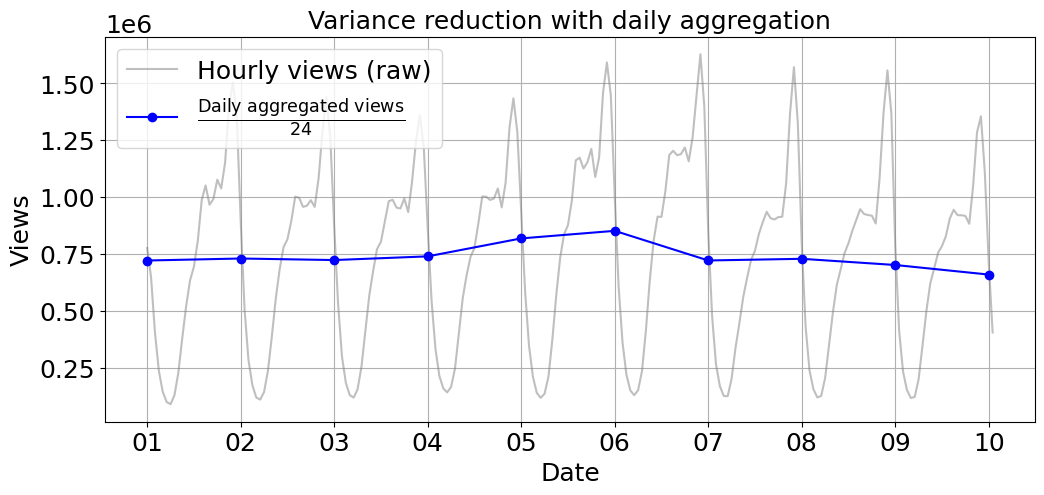

In [ ]:
import matplotlib.dates as mdates

plt.rcParams.update({
    "font.size": 18,        # base font size
    "axes.titlesize": 18,   # title size
    "axes.labelsize": 18,   # x/y labels
    "xtick.labelsize": 18,  # x tick labels
    "ytick.labelsize": 18,  # y tick labels
    "legend.fontsize": 18,  # legend
})

plt.figure(figsize=(12,5))

# Raw hourly (noisy)
plt.plot(hourly_pd["datetime"][0:218], hourly_pd["views_hour"][0:218], color="gray", alpha=0.5, label="Hourly views (raw)")

# Daily (smoothed)
plt.plot(daily_pd["date"], daily_pd["views_day"]/24, color="blue", marker="o", label=r"$\frac{\text{Daily aggregated views}}{24}$")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d"))

plt.title("Variance reduction with daily aggregation")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.types import BooleanType


from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import BooleanType
from typing import Union, List
from pyspark.sql import DataFrame
import datetime

SOURCE_DELTA_PATH = "/Volumes/workspace/default/wiki"
df = spark.read.format("delta").load(SOURCE_DELTA_PATH)

def build_ml_dataset(
    df: DataFrame,
    obs_start: Union[str, datetime.date],
    obs_end: Union[str, datetime.date],
    lbl_start: Union[str, datetime.date],
    lbl_end: Union[str, datetime.date],
    key_cols: List[str] = ["language", "database_name", "is_mobile", "namespace", "page_title"]
) -> DataFrame:
    """
    Build a machine learning dataset for churn prediction.

    The function transforms raw pageview logs into a supervised dataset where each row
    corresponds to a unique entity (defined by `key_cols`). It computes activity,
    recency, seasonality, and diversity features over the observation window, and
    generates churn labels based on presence in the label window.

    Args:
        df (DataFrame):
            Input Spark DataFrame with at least the following columns:
            - file_date (date or string in 'yyyy-MM-dd' format)
            - domain_code (str)
            - page_title (str)
            - count_views (int)
        obs_start (str | datetime.date):
            Start date of the observation window (inclusive).
        obs_end (str | datetime.date):
            End date of the observation window (inclusive).
            All feature computations are restricted to this period.
        lbl_start (str | datetime.date):
            Start date of the label window (inclusive).
        lbl_end (str | datetime.date):
            End date of the label window (inclusive).
            Used to determine churn labels.
        key_cols (List[str], optional):
            Columns that uniquely identify an entity.
            Defaults to ["language", "database_name", "is_mobile", "namespace", "page_title"].

    Returns:
        DataFrame:
            Spark DataFrame with one row per entity, including:

            **Aggregate features**
                - days_active: number of active days in the observation window
                - views_total, views_mean, views_max, views_median, views_std
                - trend_slope: linear regression slope of activity over time

            **Recency / rolling features**
                - views_last_day: activity on the last observation day
                - sum_3d, sum_7d: rolling sums over last 3 and 7 days

            **Seasonality features**
                - unique_weekdays: number of distinct weekdays active
                - first_dow: first weekday observed
                - views_std_dow: variation across weekdays

            **Diversity features**
                - n_domains: number of distinct domains
                - views_entropy: Shannon entropy of activity distribution across domains
                - views_entropy_norm: entropy normalized to [0,1]

            **Sparsity indicators**
                - is_zero_history: flag if total activity is zero
                - is_sparse: flag if active ≤ 2 days
                - sparsity_level: categorical label {very_sparse, sparse, medium, frequent}

            **Label**
                - churn: 1 if the entity disappeared in label window, else 0

            **Metadata**
                - domain_code: last-seen domain code for the entity

    Notes:
        - Protects against data leakage by restricting features strictly to the
          observation window (`obs_start`–`obs_end`).
        - Label generation compares presence in the label window (`lbl_start`–`lbl_end`).
        - Assumes `file_date` is compatible with Spark date functions and
          comparable to the provided window boundaries.
    """
    # ----------------------
    # Filter obs + churn
    # ----------------------
    obs_df = df.filter(
        (F.col("file_date") >= F.lit(obs_start)) &
        (F.col("file_date") <= F.lit(obs_end))
    )
    lbl_df = df.filter(
        (F.col("file_date") >= F.lit(lbl_start)) &
        (F.col("file_date") <= F.lit(lbl_end))
    )

    # ----------------------
    # Daily aggregates
    # ----------------------
    obs_df = obs_df.withColumn("dow", F.dayofweek("file_date"))  # 1=Sunday, 7=Saturday

    daily = (
        obs_df.groupBy(["file_date","dow"] + key_cols)
        .agg(F.sum("count_views").alias("views_day"))
    )

    # ----------------------
    # Rolling sums (no leakage)
    # ----------------------
    time_w = Window.partitionBy(key_cols).orderBy(F.col("file_date")).rowsBetween(-6, 0)
    time_w3 = Window.partitionBy(key_cols).orderBy(F.col("file_date")).rowsBetween(-2, 0)
    daily = (daily
             .withColumn("sum_7d", F.sum("views_day").over(time_w))
             .withColumn("sum_3d", F.sum("views_day").over(time_w3)))

    # ----------------------
    # Last day snapshot
    # ----------------------
    last_day = (daily.filter(F.col("file_date") == F.lit(obs_end))
                .select(key_cols + ["views_day","sum_7d","sum_3d"])
                .withColumnRenamed("views_day","views_last_day"))

    # ----------------------
    # Aggregate features
    # ----------------------
    agg_feats = (
        daily.groupBy(key_cols)
        .agg(
            F.countDistinct("file_date").alias("days_active"),
            F.sum("views_day").alias("views_total"),
            F.avg("views_day").alias("views_mean"),
            F.max("views_day").alias("views_max"),
            F.stddev_pop("views_day").alias("views_std"),
            F.percentile_approx("views_day", 0.5).alias("views_median"),
            F.regr_slope(
                "views_day",
                F.datediff(F.col("file_date"), F.to_date(F.lit(obs_start)))
            ).alias("trend_slope"),
            F.countDistinct("dow").alias("unique_weekdays"),
            F.first(F.dayofweek(F.col("file_date"))).alias("first_dow"),
            F.expr("stddev_pop(views_day)").alias("views_std_dow")
        )
    )



    # ----------------------
    # Merge features
    # ----------------------
    features = (agg_feats
                .join(last_day, on=key_cols, how="left")
                .join(entropy, on=key_cols, how="left")
                .fillna({
                    "views_last_day":0,
                    "sum_7d":0,
                    "sum_3d":0,
                    "views_entropy":0.0,
                    "views_entropy_norm":0.0
                })
                # --- Sparsity guards ---
                .withColumn("is_zero_history", (F.col("views_total")==0).cast(BooleanType()))
                .withColumn("is_sparse", (F.col("days_active")<=2).cast(BooleanType()))
                .withColumn("sparsity_level",
                            F.when(F.col("days_active")<=2,"very_sparse")
                             .when(F.col("days_active")<=5,"sparse")
                             .when(F.col("days_active")<=8,"medium")
                             .otherwise("frequent"))
               )

    # ----------------------
    # Labels
    # ----------------------
    alive_keys = lbl_df.select(key_cols).distinct().withColumn("alive_flag", F.lit(1))
    obs_keys = daily.select(key_cols).distinct()
    labels = (obs_keys.join(alive_keys, on=key_cols, how="left")
              .withColumn("churn", F.when(F.col("alive_flag").isNull(),1).otherwise(0))
              .drop("alive_flag"))

    # ----------------------
    # Join features + labels
    # ----------------------
    ml_dataset = features.join(labels, on=key_cols, how="inner")

    # ----------------------
    # Add last-seen domain_code
    # ----------------------
    domain_last = (
        obs_df
        .withColumn("rn", F.row_number().over(Window.partitionBy(key_cols).orderBy(F.col("file_date").desc())))
        .filter(F.col("rn")==1)
        .select(key_cols + ["domain_code"])
    )
    ml_dataset = ml_dataset.join(domain_last, on=key_cols, how="left")

    return ml_dataset



train_set = build_ml_dataset(
    df,
    obs_start="2025-01-01", obs_end="2025-01-23",
    lbl_start="2025-01-24", lbl_end="2025-01-27"
)

# train_set = train_set.sample(fraction=0.01)

# Select relevant columns
corr_df = train_set.select("churn", "views_last_day", "sum_3d", "sum_7d").toPandas()

In [ ]:
corr_df_day_3 = train_set.select("churn", "views_last_day", "sum_3d", "sum_7d").toPandas()

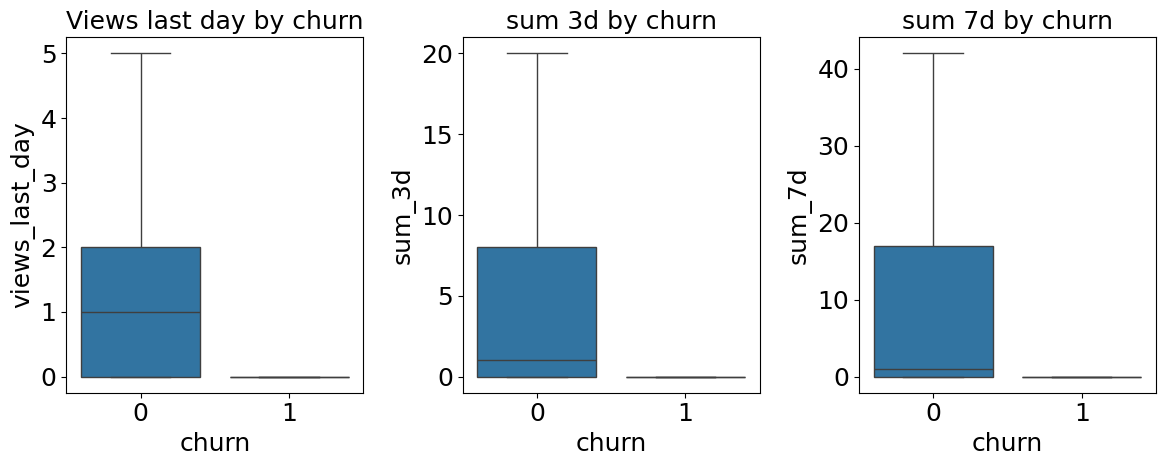

In [ ]:
#-----------------------
# Rolling windows (3-day and 7-day sums) + Last-day snapshot
#-----------------------

import seaborn as sns


fig, axes = plt.subplots(1, 3, figsize=(12,5))

# Correlation of churn vs 3-day sum
sns.boxplot(x="churn", y="views_last_day", data=corr_df_day_3, ax=axes[0], showfliers=False)
axes[0].set_title("Views last day by churn")

sns.boxplot(x="churn", y="sum_3d", data=corr_df_day_3, ax=axes[1], showfliers=False)
axes[1].set_title("sum 3d by churn")

sns.boxplot(x="churn", y="sum_7d", data=corr_df_day_3, ax=axes[2], showfliers=False, showmeans=False)
axes[2].set_title("sum 7d by churn")



plt.tight_layout()
plt.show()

In [ ]:
corr_df_days = train_set.select("churn", "views_total", "views_mean", "views_max", "views_std", "views_median", "trend_slope").toPandas()

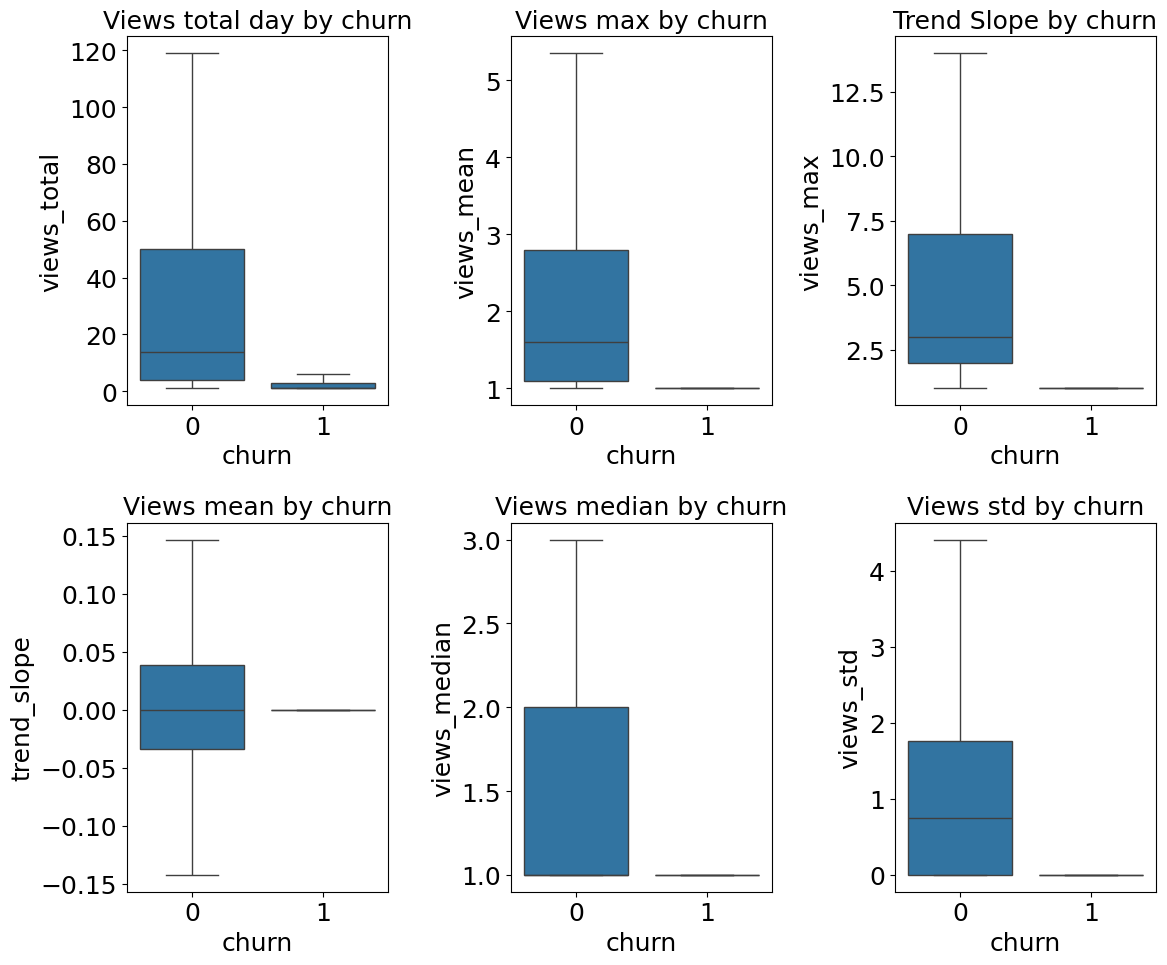

In [ ]:
#-----------------------
# Total views: the sum of all views in the period.
# → Measures overall intensity (how big the activity was).
# Mean views: the average number of views per day.
# → Gives a baseline for “typical” activity.
# Max views: the highest number of views in a single day.
# → Captures peak popularity.
# Standard deviation: how much the daily counts fluctuate around the mean.
# → High std = spiky, unstable activity; low std = stable, consistent activity.
# Median: the middle value.
# → More robust than the mean, especially if there are extreme peaks.
# Regression slope (trend_slope): the slope of a line fitted through daily activity over time.
# → Positive slope = activity is growing; negative slope = activity is declining.
#-----------------------


fig, axes = plt.subplots(2, 3, figsize=(12,10))

# Correlation of churn vs 3-day sum
sns.boxplot(x="churn", y="views_total", data=corr_df_days, ax=axes[0,0], showfliers=False)
axes[0,0].set_title("Views total day by churn")

sns.boxplot(x="churn", y="trend_slope", data=corr_df_days, ax=axes[1,0], showfliers=False, showmeans=False)
axes[1,0].set_title("Views mean by churn")

sns.boxplot(x="churn", y="views_mean", data=corr_df_days, ax=axes[0,1], showfliers=False)
axes[0,1].set_title("Views max by churn")

sns.boxplot(x="churn", y="views_median", data=corr_df_days, ax=axes[1,1], showfliers=False, showmeans=False)
axes[1,1].set_title("Views median by churn")

sns.boxplot(x="churn", y="views_max", data=corr_df_days, ax=axes[0,2], showfliers=False, showmeans=False)
axes[0,2].set_title("Trend Slope by churn")

sns.boxplot(x="churn", y="views_std", data=corr_df_days, ax=axes[1,2], showfliers=False, showmeans=False)
axes[1,2].set_title("Views std by churn")


plt.tight_layout()
plt.show()

In [ ]:
corr_df_dow = train_set.select("churn", "unique_weekdays", "first_dow", "views_std_dow").toPandas()

Text(0.5, 1.0, 'Views std dow by churn')

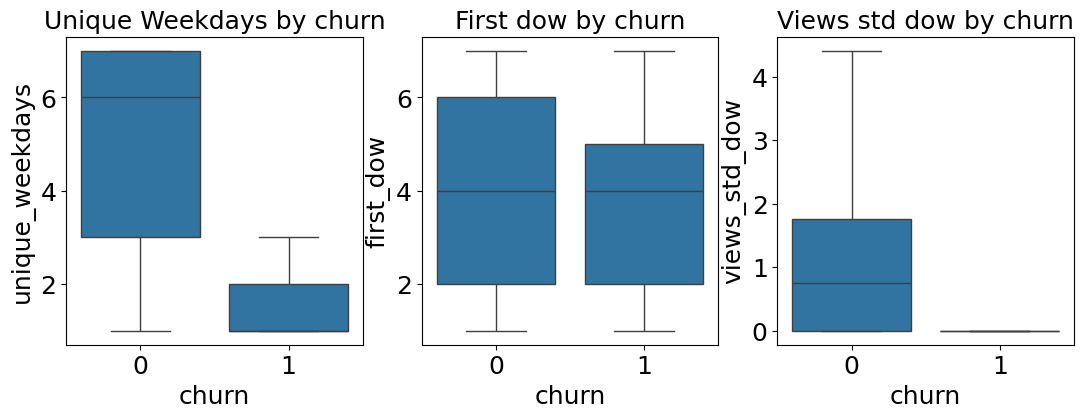

In [ ]:

# unique_weekdays: informative — churned entities are often active on fewer weekdays (low diversity).
# first_dow: usually weak — the first day of activity is often arbitrary, not predictive.
# views_std_dow: can be informative — if an entity only spikes on a specific weekday (e.g., only Fridays), it’s less stable than one with uniform engagement.



fig, axes = plt.subplots(1, 3, figsize=(13,4))

# Correlation of churn vs 3-day sum
sns.boxplot(x="churn", y="unique_weekdays", data=corr_df_dow, ax=axes[0], showfliers=False)
axes[0].set_title("Unique Weekdays by churn")

sns.boxplot(x="churn", y="first_dow", data=corr_df_dow, ax=axes[1], showfliers=False)
axes[1].set_title("First dow by churn")

sns.boxplot(x="churn", y="views_std_dow", data=corr_df_dow, ax=axes[2], showfliers=False, )
axes[2].set_title("Views std dow by churn")


In [ ]:
ml_df = train_set.select("churn", "is_zero_history", "is_sparse", "sparsity_level").toPandas()

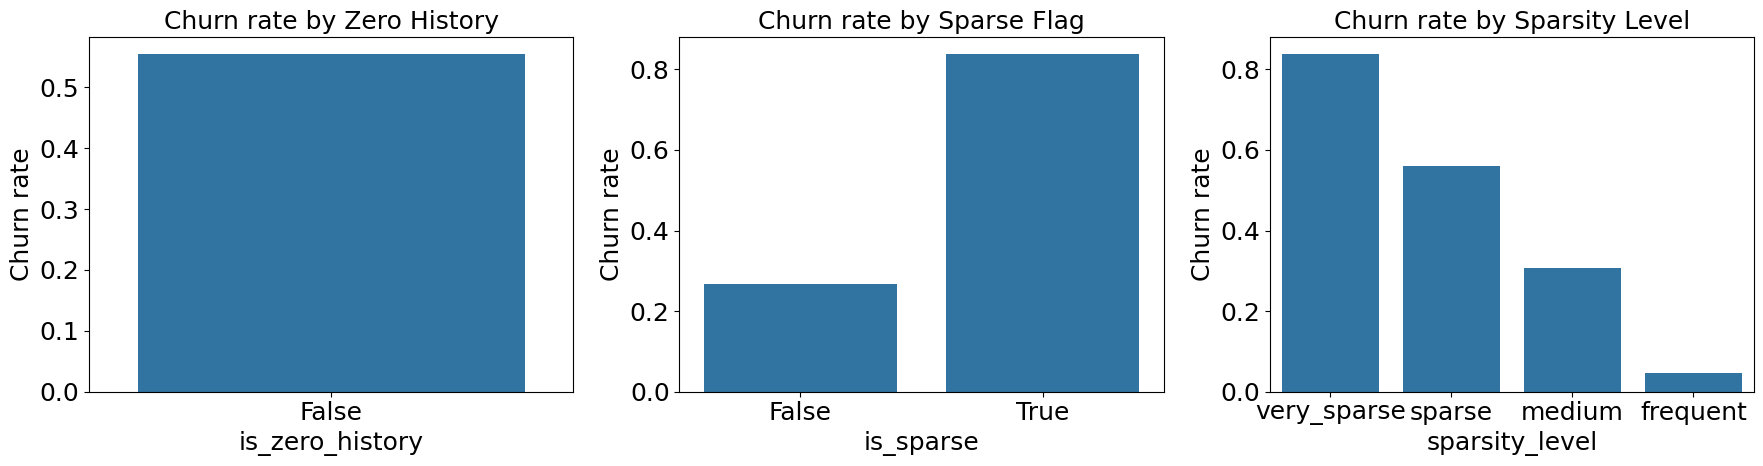

In [ ]:


#. Sparsity level vs churn


fig, axes = plt.subplots(1, 1, figsize=(18, 5))


sns.barplot(
    x="sparsity_level", y="churn", data=ml_df,
    estimator=np.mean, ci=None, ax=axes[0],
    order=["very_sparse", "sparse", "medium", "frequent"]
)
axes[0].set_title("Churn rate by Sparsity Level")
axes[0].set_ylabel("Churn rate")
axes[0].set_xlabel("sparsity_level")

plt.tight_layout()
plt.show()